# <center>Improving going-concern assumption through machine learning</center>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import norm, spearmanr
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

### Working sample

Sample consists of 100 entities operating in the construction sector in Bulgaria. 50% of them are declared bankrupt in 2021. 50% of them are with good financial performance. All the necessary data are derived from the Bulgarian Commercial Register.

In [2]:
gc_data = pd.read_excel("data/sample.xlsx")

In [3]:
gc_data.head()

,COMPANY,ID_COM_REG,TLTA,RETA,QACL,NITA,CLASS
0,VODOPROVODI I KANALI EOOD,202638174,3.131944,-1.378472,0.018847,0.21700,NGC
1,JuLISIS 09 EOOD,200543293,0.857576,0.124242,0.085714,0.00318,NGC
2,AVE-STROJ EOOD,105544996,0.752412,0.199357,0.248366,0.03499,NGC
3,ALERLO EOOD,204845976,0.000000,0.000000,0.000000,0.00000,NGC
4,OKSET EOOD,200760731,0.000000,0.000000,0.000000,-1.00000,NGC


### Feature selection and preprocessing

Being features with high entropy, COMPANY and ID_COM_REG are ignored for the analysis.

In [4]:
features = gc_data[["TLTA", "RETA", "QACL","NITA"]]
target = gc_data["CLASS"]

Features are fit to normal distribution by applying log transformation. NaN and inf/-inf values are replaced with 0.

In [5]:
def fit_normal_distr(features, target):
    
    # Applying log transformation to fit to normal distribution
    norm_features = np.log1p(features)
    
    # Reaplacing values where log has returnd "inf" or "nan" with 0
    norm_features.replace([np.inf, -np.inf], 0, inplace=True)
    norm_features.fillna(value=0, axis=1, inplace=True)
      
    # Performs normalization
    normalizer = MinMaxScaler(copy=False)
    normalizer.fit_transform(norm_features)
    
    # One-Hot-Encoding target variable
    encoder = LabelBinarizer()
    target = encoder.fit_transform(target)
    
    
    return norm_features, target

In [6]:
norm_features, target = fit_normal_distr(features, target)

Plotting features before and after preprocessing.

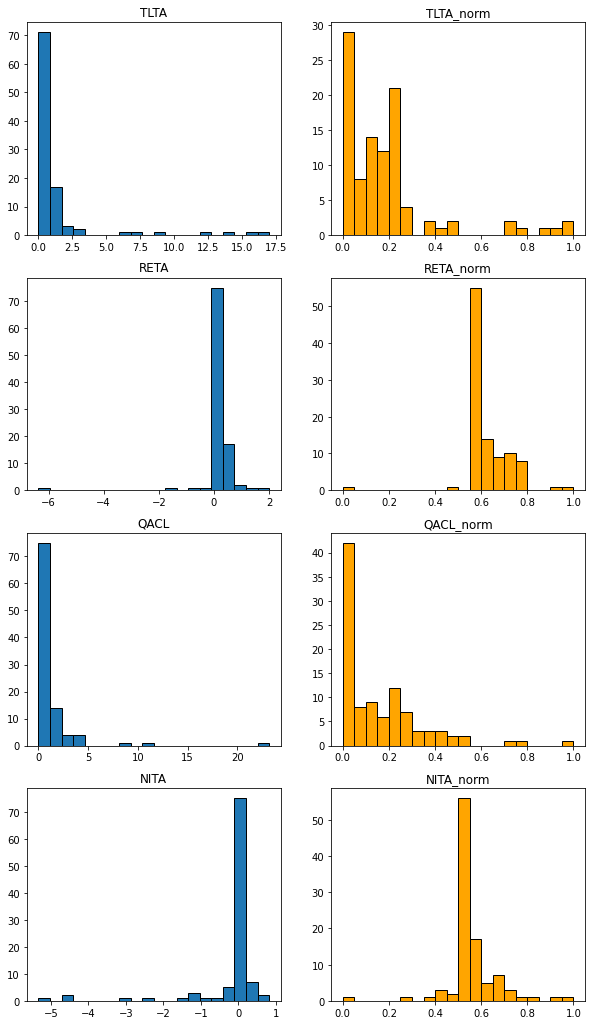

In [7]:
# Plots features before and after preprocessing

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,18))
fig.canvas.set_window_title('Window Title')

axs[0, 0].hist(features["TLTA"], edgecolor='black', bins=20)
axs[0, 0].set_title("TLTA")
axs[0, 1].hist(norm_features["TLTA"], edgecolor='black', bins=20, color="orange")
axs[0, 1].set_title("TLTA_norm")

axs[1, 0].hist(features["RETA"], edgecolor='black', bins=20)
axs[1, 0].set_title("RETA")
axs[1, 1].hist(norm_features["RETA"], edgecolor='black', bins=20, color="orange")
axs[1, 1].set_title("RETA_norm")

axs[2, 0].hist(features["QACL"], edgecolor='black', bins=20)
axs[2, 0].set_title("QACL")
axs[2, 1].hist(norm_features["QACL"], edgecolor='black', bins=20, color="orange")
axs[2, 1].set_title("QACL_norm")

axs[3, 0].hist(features["NITA"], edgecolor='black', bins=20)
axs[3, 0].set_title("NITA")
axs[3, 1].hist(norm_features["NITA"], edgecolor='black', bins=20, color="orange")
axs[3, 1].set_title("NITA_norm")

plt.savefig("norm")
plt.show()

In [8]:
# Creating a new dataframe in order to calculate correlation between features and target variable.
corr_df = norm_features[["TLTA", "RETA", "QACL","NITA"]].copy()
corr_df["CLASS"] = target.copy()

In [9]:
corr_df

,TLTA,RETA,QACL,NITA,CLASS
0,0.490853,0.574217,0.005859,0.689508,1
1,0.214254,0.619604,0.025806,0.539741,1
2,0.194090,0.644671,0.069612,0.563938,1
3,0.000000,0.574217,0.000000,0.537280,1
4,0.000000,0.574217,0.000000,0.537280,1
...,...,...,...,...,...
95,0.083436,0.000000,0.265883,0.928138,0
96,0.384048,0.574217,0.062487,0.537280,0
97,0.152877,0.574217,0.140559,0.708955,0
98,0.113143,0.717217,0.103398,0.532142,0


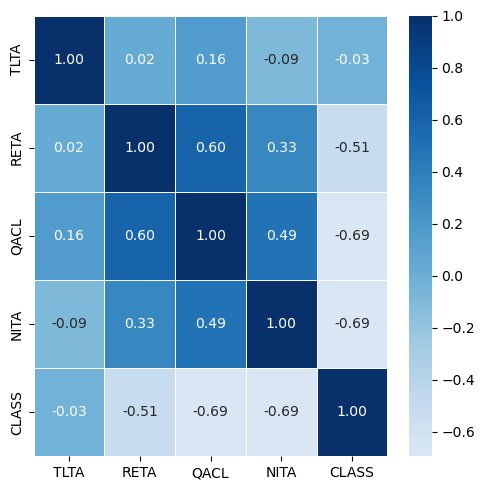

In [10]:
plt.figure(figsize=(5,5), dpi=100)
sns.heatmap(corr_df.corr(method="spearman"), annot=True, linewidth=0.5, fmt=".2f", cmap="Blues", center = 0)
plt.tight_layout()
plt.savefig("corrmatrix")
plt.show()

### KNN Model

The first algorithm to be implemented is k-Nearest Neighbor (kNN). It would be hypertuned (number of neighbors from 1 to 24) through GridSearchCV. 

In [17]:
# Setting a parameter grid which contains different values of number of neighbors (from 1 to 24)

parameter_grid = {"n_neighbors": np.arange(1, 25)}

In [18]:
parameter_grid

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24])}

In [19]:
knn_classifier = KNeighborsClassifier()

In [20]:
# Applying 10-fold cross-validation

knn_gscv = GridSearchCV(knn_classifier, param_grid=parameter_grid, cv=10, return_train_score=True)

In [21]:
knn_gscv.fit(norm_features, target)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             return_train_score=True)

In [22]:
knn_gscv.best_estimator_

KNeighborsClassifier(n_neighbors=6)

In [23]:
knn_gscv.best_score_

0.8800000000000001

In [24]:
knn = knn_gscv.best_estimator_

In [25]:
knn_predictions = knn.predict(norm_features)

In [26]:
actuals = target

In [27]:
# Function which plots test vs train accuracy

def plot_train_test_score(test_score, train_score, x, best_parameter, xlabel, ylabel, xticks):
    plt.figure(figsize=(8,5))
    plt.plot(x, test_score, label="test_score")
    plt.plot(x, train_score, label="train_score")
    plt.axvline(x=best_parameter, color="r", ls="--", label="best_score")
    plt.xlabel(xlabel, fontsize=18)
    plt.xticks(xticks)
    plt.ylabel(ylabel, fontsize=18)
    plt.legend(prop={'size': 15})
    plt.tight_layout()
    plt.savefig("train_test_plot_knn.png")
    plt.show()

In [28]:
def plot_confusion_matrix(actuals, predictions,fig_name="fig_name", save=False):
    conf_matrix = confusion_matrix(actuals, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["GC", "NGC"])
    fig, ax = plt.subplots(figsize=(7,6))
    plt.tight_layout()
    cm_display.plot(ax=ax, colorbar=False)
    font = {'family': 'sans-serif',
    'weight': 'bold',
    'size': 15}
    plt.rc('font', **font)
    if save:
        plt.savefig(fig_name, dpi=300)
    plt.show()

In [29]:
def precision_recall(actuals, predictions):
    precision = precision_score(predictions, actuals)
    recall = recall_score(predictions, actuals)
    print(f"kNN precision: {precision:.2f}")
    print(f"kNN recall: {recall:.2f}")

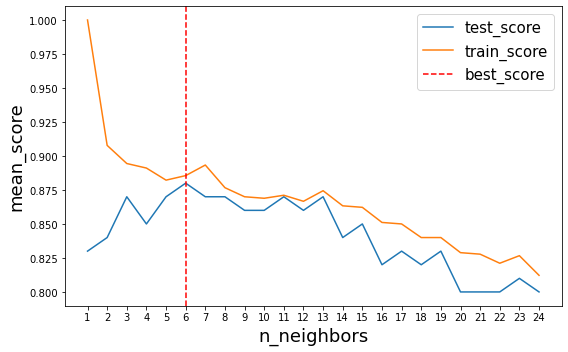

In [30]:
plot_train_test_score(test_score=knn_gscv.cv_results_["mean_test_score"], 
                      train_score=knn_gscv.cv_results_["mean_train_score"],
                      x=parameter_grid["n_neighbors"],
                      best_parameter=knn_gscv.best_params_["n_neighbors"],
                      xlabel="n_neighbors",
                      ylabel="mean_score",
                      xticks=parameter_grid["n_neighbors"])

The number of neighbors which yields highest classification (0.88) is 6.

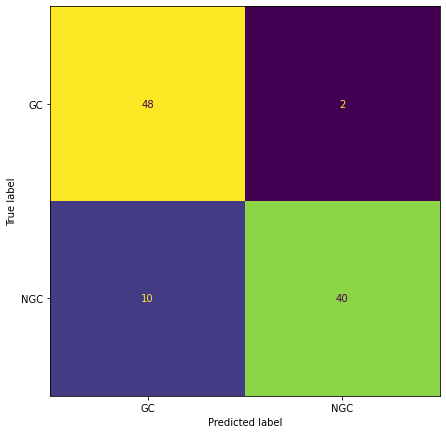

In [31]:
plot_confusion_matrix(actuals, knn_predictions, "knn_conf_matrix", save=True)

In [32]:
precision_recall(target, knn_predictions)

kNN precision: 0.80
kNN recall: 0.95


### Linear Regression

In [33]:
alphas_grid = [0.001, 0.01, 0.1, 1, 10]

In [34]:
ridgereg = RidgeClassifierCV(alphas=alphas_grid, cv=5)
ridgereg.fit(norm_features, actuals)

RidgeClassifierCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), cv=5)

In [35]:
ridgereg.best_score_

0.85

In [36]:
ridgereg.alpha_

0.001

In [37]:
ridge_predictions = ridgereg.predict(norm_features)
actuals = target

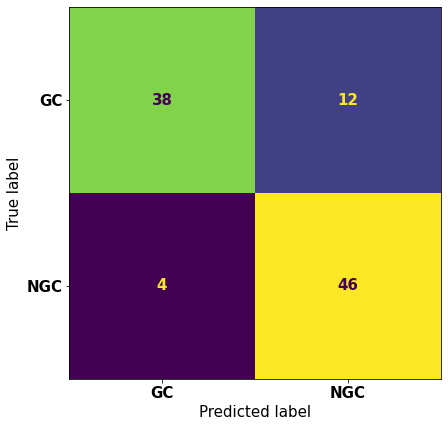

In [38]:
plot_confusion_matrix(actuals, ridge_predictions, fig_name="ridge_conf_matrix", save=True)

In [39]:
precision_recall(target, ridge_predictions)

kNN precision: 0.92
kNN recall: 0.79


### Decision Tree

In [44]:
params =  {
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [1, 2, 3 , 4],
    'max_depth': [1, 2, 3, 4]}

In [45]:
dt = DecisionTreeClassifier(random_state=42)

In [46]:
dt_gscv = GridSearchCV(dt, params, cv=10, return_train_score=True)

In [47]:
dt_gscv.fit(norm_features, target)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 3, 4]},
             return_train_score=True)

In [48]:
dt_gscv.best_estimator_

DecisionTreeClassifier(max_depth=3, max_features=2, min_samples_leaf=2,
                       random_state=42)

In [49]:
dt_gscv.best_score_

0.89

In [50]:
best_dt = dt_gscv.best_estimator_

In [51]:
best_dt.fit(norm_features, target)

DecisionTreeClassifier(max_depth=3, max_features=2, min_samples_leaf=2,
                       random_state=42)

In [52]:
dt_predictions = best_dt.predict(norm_features)

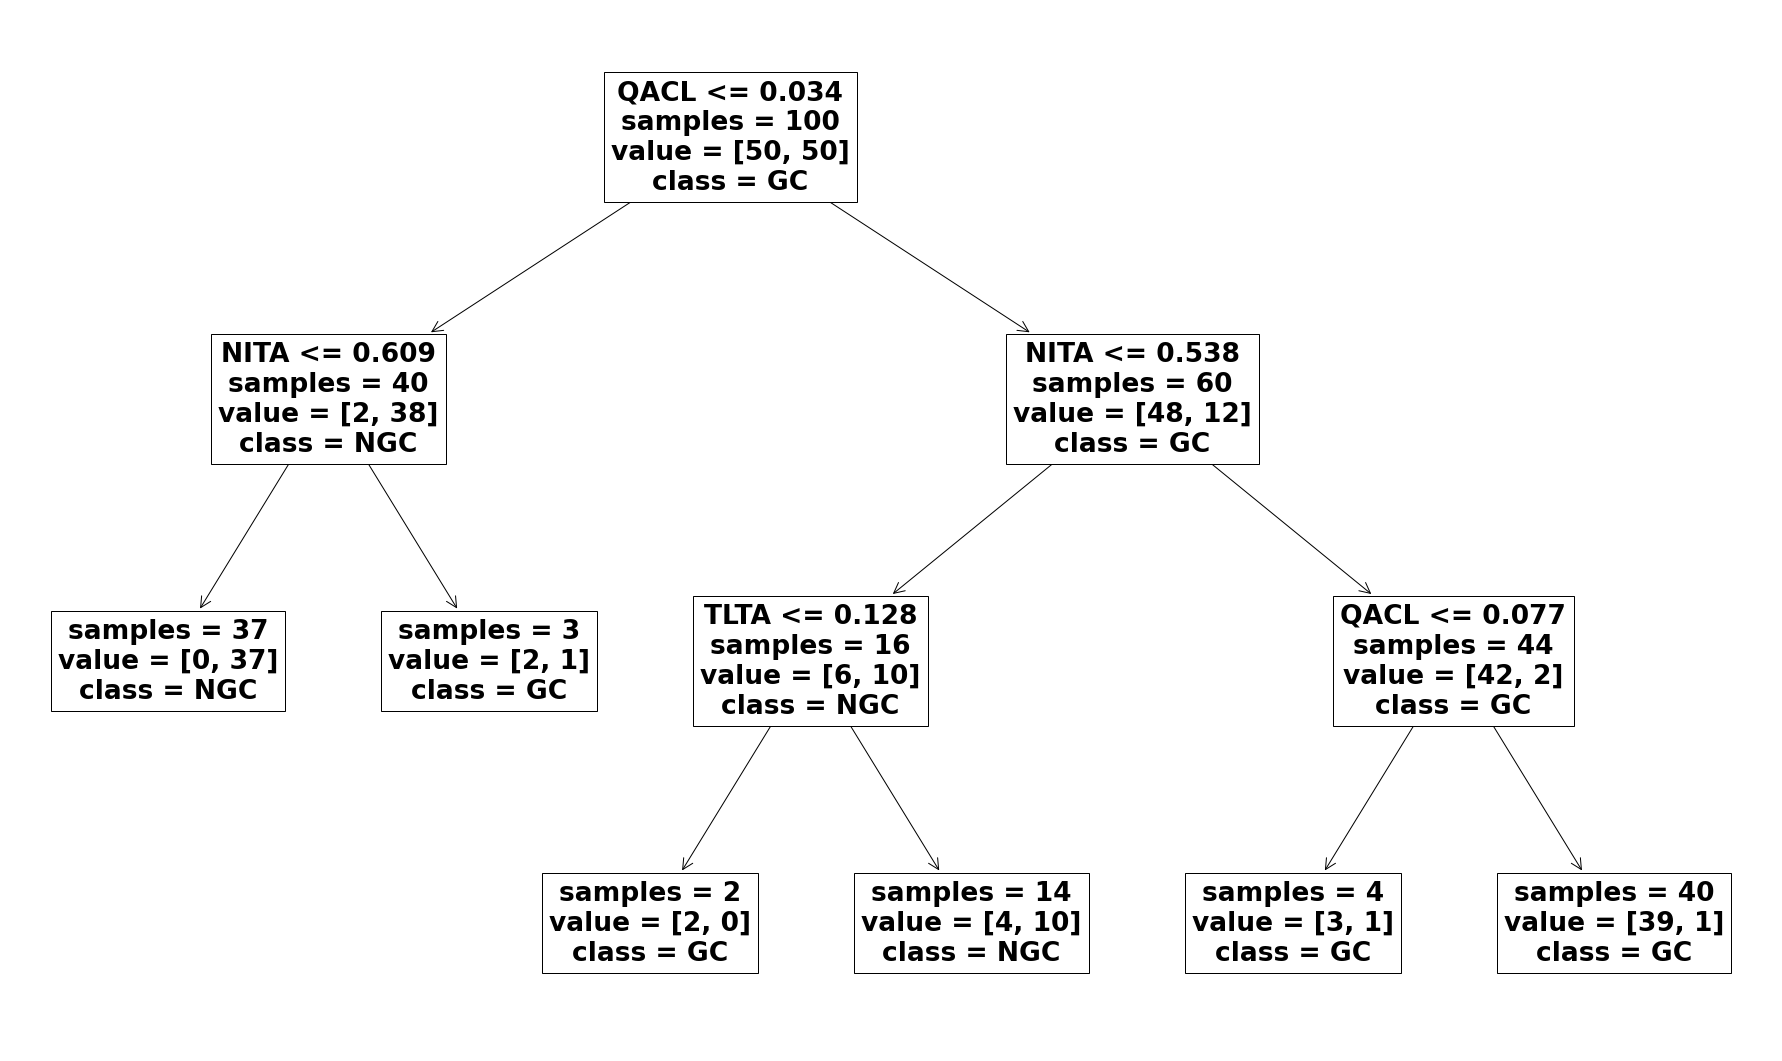

In [53]:
plt.figure(figsize=(25,15))
plot_tree(best_dt,feature_names=norm_features.columns.tolist(), class_names=["GC", "NGC"], filled=False, impurity=False)
plt.tight_layout()
plt.savefig("tree", dpi=300)
font = {'family': 'sans-serif',
    'weight': 'bold',
    'size': 20}
plt.rc('font', **font)
plt.show()

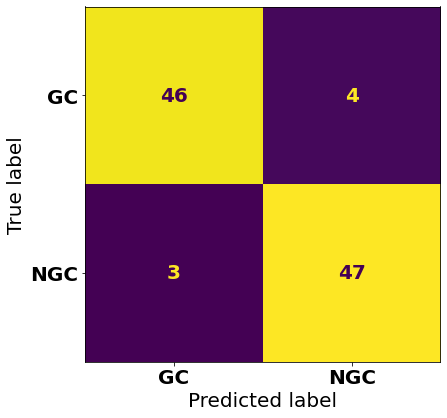

In [54]:
plot_confusion_matrix(target, dt_predictions, fig_name="dt_conf_matrix", save=True)

In [55]:
precision_recall(target, dt_predictions)

kNN precision: 0.94
kNN recall: 0.92
